In [1]:
import pygame
from pygame.locals import *
import random
import numpy as np
from OpenGL.GL import *
from OpenGL.GLUT import *
from OpenGL.GLU import *

import sys
sys.path.insert(0, '../')
from src.time_tagger import TT_Simulator, two_particle_states

pygame 2.5.2 (SDL 2.28.3, Python 3.10.11)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
SimulatorPhiPlus = TT_Simulator(two_particle_states['phi_plus'], initial_state_noise=0, debug=False)
CHSH_angles = SimulatorPhiPlus.CHSH_angles_for_filters

theta_a = np.random.choice(CHSH_angles[0:2])
theta_b = np.random.choice(CHSH_angles[2:4])

theta_a = 0
theta_b = 0

outcomeProbabilities = SimulatorPhiPlus.outcome_probabilities(theta_a, theta_b)[:,0]
print(outcomeProbabilities)

[0.5 0.  0.  0.5]


In [3]:
# Initialize Pygame
pygame.init()

# Set up display for 1080p windowed mode
display = (500, 400)
pygame.display.set_mode(display, DOUBLEBUF | OPENGL)

# Adjust the orthographic projection to account for display size
gluOrtho2D(0, display[0], 0, display[1])

# Initial positions for the random walks
walks = [
    {
        "x": display[0] // 4,
        "y": display[1] // 2,
        "path": [(display[0] // 4, display[1] // 2)],
        "color": (1.0, 0.0, 0.0),  # Red
        "path_color": (1.0, 0.5, 0.5)  # Light Red
    },
    {
        "x": 3 * display[0] // 4,
        "y": display[1] // 2,
        "path": [(3 * display[0] // 4, display[1] // 2)],
        "color": (0.0, 1.0, 0.0),  # Green
        "path_color": (0.9, 1.0, 0.9)  # Light Green
    }
]

# Initialize the third point
midpoint = {
    "x": (walks[0]["x"] + walks[1]["x"]) // 2,
    "y": (walks[0]["y"] + walks[1]["y"]) // 2,
    "path": [((walks[0]["x"] + walks[1]["x"]) // 2, (walks[0]["y"] + walks[1]["y"]) // 2)],
    "color": (0.0, 0.0, 1.0),  # Blue
    "path_color": (0.5, 0.5, 1.0)  # Light Blue
}

# Function to perform a random walk step
def random_walk_step(walker, walk):
    direction = np.random.choice(a=['HH', 'HV', 'VH', 'VV'], p=outcomeProbabilities)
    if direction[walker] == 'H':
        walk['x'] += np.random.choice([1, -1])
    elif direction[walker] == 'V':
        walk['y'] += np.random.choice([1, -1])

    walk['path'].append((walk['x'], walk['y']))

# Function to update the midpoint
def update_midpoint(midpoint, walk1, walk2):
    midpoint["x"] = (walk1["x"] + walk2["x"]) // 2
    midpoint["y"] = (walk1["y"] + walk2["y"]) // 2
    midpoint["path"].append((midpoint["x"], midpoint["y"]))

# Function to draw the walk path
def draw_path(walk):
    glBegin(GL_LINES)
    glColor3f(*walk['path_color'])
    for i in range(len(walk['path']) - 1):
        glVertex2f(*walk['path'][i])
        glVertex2f(*walk['path'][i + 1])
    glEnd()

# Function to draw the current point
def draw_current_point(walk):
    glColor3f(*walk['color'])
    glPointSize(5.0)  # Point size without scaling
    glBegin(GL_POINTS)
    glVertex2f(walk['x'], walk['y'])
    glEnd()

# Main loop
running = True
while running:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False

    for walker, walk in enumerate(walks):
        random_walk_step(walker, walk)
    
    # Update the midpoint position
    update_midpoint(midpoint, walks[0], walks[1])
    
    # Clear screen
    glClear(GL_COLOR_BUFFER_BIT | GL_DEPTH_BUFFER_BIT)
    
    # Draw paths and current points for both walks
    for walk in walks:
        draw_path(walk)
        draw_current_point(walk)
    
    # Draw path and current point for the midpoint
    draw_path(midpoint)
    draw_current_point(midpoint)
    
    # Update display
    pygame.display.flip()
    pygame.time.wait(10)

pygame.quit()

The above code works (and the basis choice is represented as the random choice between positive and negative movement)
The problem is that each successive movement is not related to the previous one thus even though for each individual movement there is a correlation between how A and B moved overall there is no structure in the midpoint dot. We somehow need to make it clear that there is a relationship between A and B

Maybe coloring each move based on if the two particles had a correlated behaviour. if both go horizontal its blue, if both go vertical its red. otherwise its white. This doesnt take into account the basis choice though and we dont see correlations if they are HV and VH

Maybe could do something so that if correlations are there the thrid particle remains in a tighter circle and if not the moves get bigger and it walks a bigger circle

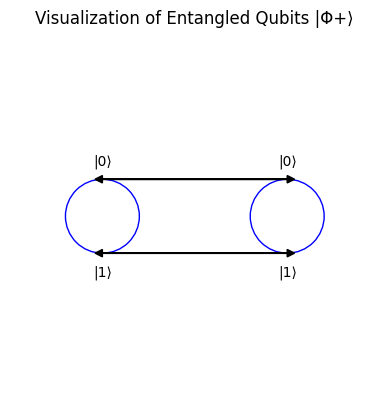

In [15]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

# Draw circles for qubits
circle1 = plt.Circle((0.25, 0.5), 0.1, color='b', fill=False)
circle2 = plt.Circle((0.75, 0.5), 0.1, color='b', fill=False)

ax.add_artist(circle1)
ax.add_artist(circle2)

# Annotate states
ax.text(0.25, 0.65, '|0⟩', ha='center', va='center')
ax.text(0.25, 0.35, '|1⟩', ha='center', va='center')
ax.text(0.75, 0.65, '|0⟩', ha='center', va='center')
ax.text(0.75, 0.35, '|1⟩', ha='center', va='center')

# Draw entanglement lines
plt.arrow(0.25, 0.6, 0.5, 0, head_width=0.02, head_length=0.02, fc='k', ec='k')
plt.arrow(0.75, 0.6, -0.5, 0, head_width=0.02, head_length=0.02, fc='k', ec='k')
plt.arrow(0.25, 0.4, 0.5, 0, head_width=0.02, head_length=0.02, fc='k', ec='k')
plt.arrow(0.75, 0.4, -0.5, 0, head_width=0.02, head_length=0.02, fc='k', ec='k')

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_aspect('equal')

plt.title("Visualization of Entangled Qubits |Φ+⟩")
plt.axis('off')
plt.show()


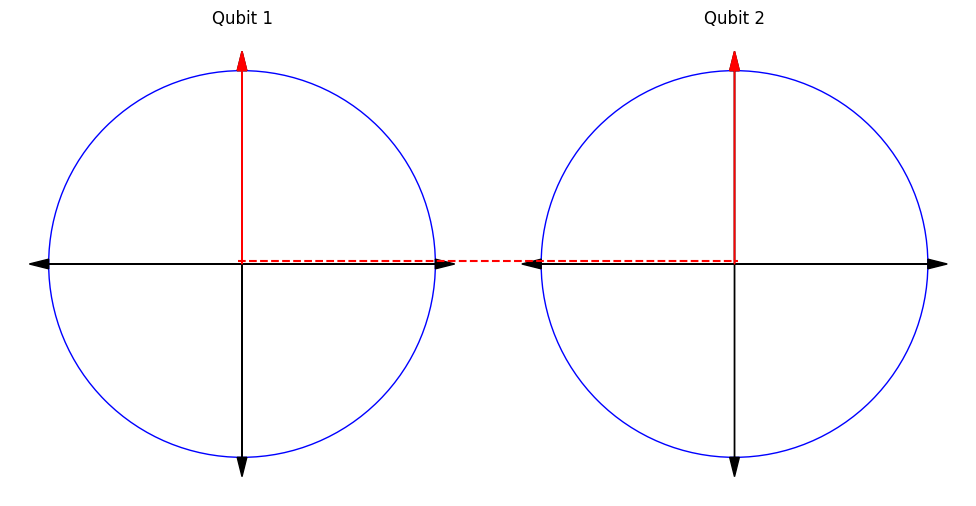

In [19]:

# Function to plot a simple Bloch sphere
def plot_bloch_sphere(ax, vector, title):
    # Draw the outer circle of the Bloch sphere
    circle = plt.Circle((0, 0), 1, color='b', fill=False)
    ax.add_artist(circle)
    
    # Draw axes
    ax.arrow(0, 0, 1, 0, head_width=0.05, head_length=0.1, fc='k', ec='k')
    ax.arrow(0, 0, 0, 1, head_width=0.05, head_length=0.1, fc='k', ec='k')
    ax.arrow(0, 0, -1, 0, head_width=0.05, head_length=0.1, fc='k', ec='k')
    ax.arrow(0, 0, 0, -1, head_width=0.05, head_length=0.1, fc='k', ec='k')
    
    # Plot the state vector
    ax.arrow(0, 0, vector[0], vector[1], head_width=0.05, head_length=0.1, fc='r', ec='r')
    
    # Set plot limits and title
    ax.set_xlim(-1.2, 1.2)
    ax.set_ylim(-1.2, 1.2)
    ax.set_aspect('equal')
    ax.set_title(title)
    ax.axis('off')

# Define the Bloch vectors for |Φ+⟩ state
bloch_vector_1 = [0, 1]  # Simplified to 2D for illustration
bloch_vector_2 = [0, 1]  # Simplified to 2D for illustration

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot Bloch sphere for the first qubit
plot_bloch_sphere(axes[0], bloch_vector_1, title="Qubit 1")

# Plot Bloch sphere for the second qubit
plot_bloch_sphere(axes[1], bloch_vector_2, title="Qubit 2")

# Add lines to indicate entanglement
line = plt.Line2D([0.25, 0.75], [0.5, 0.5], color='r', linestyle='--')
fig.add_artist(line)

plt.tight_layout()
plt.show()


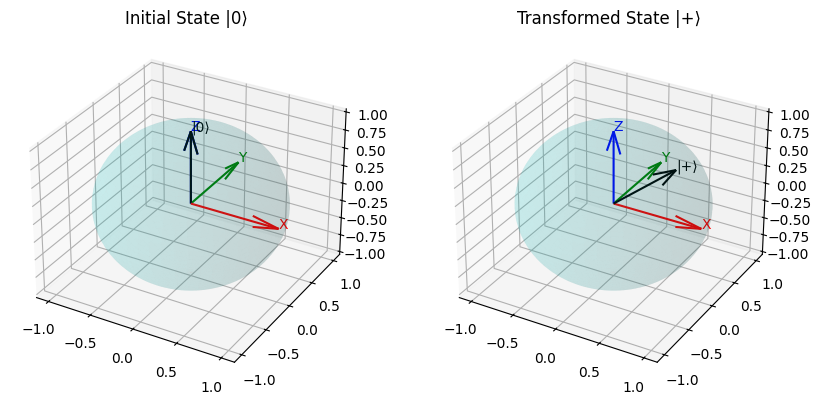

In [20]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def plot_bloch_sphere(ax):
    # Draw the Bloch sphere
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones(np.size(u)), np.cos(v))

    ax.plot_surface(x, y, z, color='c', alpha=0.1)

    # Draw x, y, z axes
    ax.quiver(0, 0, 0, 1, 0, 0, color='r')
    ax.quiver(0, 0, 0, 0, 1, 0, color='g')
    ax.quiver(0, 0, 0, 0, 0, 1, color='b')

    # Label the axes
    ax.text(1, 0, 0, 'X', color='r')
    ax.text(0, 1, 0, 'Y', color='g')
    ax.text(0, 0, 1, 'Z', color='b')

def plot_state_vector(ax, vector, label):
    ax.quiver(0, 0, 0, vector[0], vector[1], vector[2], color='k')
    ax.text(vector[0], vector[1], vector[2], label, color='k')

# Define the initial state vector |0⟩
initial_state = np.array([0, 0, 1])

# Define the Hadamard transformation matrix
hadamard_matrix = np.array([[1, 1], [1, -1]]) / np.sqrt(2)

# Apply the Hadamard transformation to |0⟩
transformed_state = np.dot(hadamard_matrix, np.array([1, 0]))
transformed_state_vector = np.array([transformed_state[0], 0, transformed_state[1]])

fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

# Plot the Bloch sphere and the initial state vector
plot_bloch_sphere(ax1)
plot_state_vector(ax1, initial_state, '|0⟩')

# Plot the Bloch sphere and the transformed state vector
plot_bloch_sphere(ax2)
plot_state_vector(ax2, transformed_state_vector, '|+⟩')

ax1.set_title('Initial State |0⟩')
ax2.set_title('Transformed State |+⟩')

plt.show()